In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint   

RANDOM_SEED = 1
plt.xkcd();

In [2]:
def binom_beta(a, b, n, k):
    """
    Parameters:
        a: alpha
        b: beta
        n: number of trials
        k: number of succeses
    """
    
    x = np.linspace(0,1,100)
    # prior values
    mean_prior = a/(a+b)
    prior = stats.beta.pdf(x=x, a=a, b=b)

    likelihood = stats.binom.pmf(k=k, n=n, p=x)

    # posterior values
    a_new = a + k
    b_new = b + n - k
    mean_post = a_new / (a_new+b_new)
    post = stats.beta.pdf(x=x, a=a_new, b=b_new)

    # 95% credible interval
    lwr = stats.beta.ppf(q=0.025, a=a_new, b=b_new)
    uppr = stats.beta.ppf(q=0.975, a=a_new, b=b_new)

    # indeces for plotting the credible interval
    indx1 = np.isclose(lwr, x, atol=1e-02).argmax()
    indx2 = np.isclose(uppr, x, atol=1e-02).argmax() + 1

    print(f"Number of trials: {n}")
    print(f"Number of successes: {k}")
    print(f"Prior mean: {mean_prior:.2}")
    print(f"Posterior mean: {mean_post:.2}")
    print(f"95% credible interval: ({lwr:.2}, {uppr:.2})")

    plt.figure(figsize=(18, 4))

    plt.subplot(131)
    plt.plot(x, prior)
    plt.axvline(mean_prior, linestyle='--', color='r')
    plt.xlabel('P(MTCT)')
    plt.ylabel('Probability')
    plt.title('Prior Probability')

    plt.subplot(132)
    plt.plot(x, likelihood)
    plt.xlabel('P(MTCT)')
    plt.title('Likelihood')

    plt.subplot(133)
    plt.plot(x, post)
    plt.fill_between(x=x[indx1:indx2], y1=post[indx1:indx2],
                     alpha=0.5, color='red')
    plt.axvline(mean_post, linestyle='--', color='r')
    plt.xlabel('P(MTCT)')
    plt.title('Posterior Probability')

    plt.show()

# Who would you rather date Bayes Factor or p-value?

## An overview of the differences between Frequentists and Bayesian approaches for hypothesis testing for a population proportion.

Frequentist vs Bayesian battle is one of the most "hot" topics in statistics world. On the one hand, Bayesians say that p-value is uninformative and can find statistically significant differences when in fact there are none. On the other hand, Frequentists say that prior probabilities for your hypothesis might be cheating and they come from nowhere. In this overview I will try to show the simple example for hypothesis testing for a population proportion using both approaches. However, I will not make any conclusions like "X approach is awesome, use Y approach" and leave the conclusion making for the reader. Most of the calculation will be done "by hand" with Python implementations, but I will try to keep a balance between going too much into details and skipping some parts.

Alright, let's begin! 

Consider the mother-to-child transmission (MTCT) of HIV (human immunodeficiency virus) is the ratio . You want to check whether the probability that an HIV-positive mother can transmit HIV to her baby during pregnancy, childbirth, or breastfeeding is 0.5 or less (say, 0.4). You have collected data from 50 HIV-positive women and their new-born children. 21 children were tested positive for HIV (0.42 ratio). Is there enough evidence to say that the probability of MTCT of HIV is less than a random chance given the observed data? (*Disclaimer: numbers are made up*).

### Frequentist Approach 

Let’s start with the Frequentist approach and null hypothesis significance testing framework. Under this framework we usually set our null hypothesis value to some constant and then the alternative hypothesis value could be unknown parameter is less/greater ($<$, $>$, one-tail test) or not equal ($\neq$, two-tail test) the null value. For our example we have:

* $H_0$: probability of MTCT of HIV is 50%, $P(\text{MTCT})=0.5$;
* $H_A$: probability of MTCT of HIV is less than 50%, $P(\text{MTCT})<0.5$;
* Significance level $\alpha=5\%$

In other words, we build a distribution under the assumptions that $H_0$ is true (the probability of MTCT is 0.5) and we want to check if data we collected provides enough evidence that it comes from the distribution with another probability (which is less than 0.5). Significance level is our threshold value, which is kind of arbitrary, but in most of the cases is set to 5%. We will reject the null hypothesis if the **p-value** is less than $\alpha$.

$n=50$, $k=21$

Since our data follows a Binomial distribution we can calculate the probability mass function given the null value.

In [20]:
n = 50
k = 21
h_0 = 1/2
x = np.arange(n+1)
probs = stats.binom.pmf(k=x, n=n, p=h_0)
temp = probs.copy()
temp[x>k] = 0

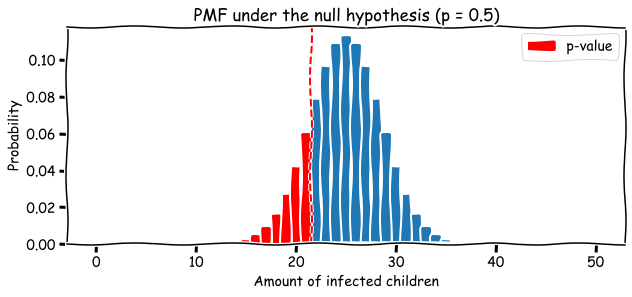

In [23]:
plt.figure(figsize=(10,4))
plt.bar(x, probs)
plt.bar(x, temp, color='r', label='p-value')
plt.axvline(k+0.5, linestyle='--', color='r')
plt.title(f'PMF under the null hypothesis (p = {h_0})')
plt.ylabel('Probability')
plt.xlabel('Amount of infected children')
plt.legend()
plt.show()

We want to know the probability of obtaining the results as extreme as the results actually observed, under the assumption that the null hypothesis is correct. Since we had a one-tail test ($<$), the "extreme" results would be obtaining 21 or less HIV infected children (red bars).

$$\text{p-value} = \sum_{i=0}^k P(X_i) = P(0) + P(1) + ... + P(21)$$
$$=\binom{50}{0} \left( \frac{1}{2} \right) ^0 \left( 1 - \frac{1}{2} \right) ^{50-0} + \binom{50}{1}\left( \frac{1}{2} \right) ^1 \left( 1 - \frac{1}{2} \right) ^{50-1} + ... + \binom{50}{21} \left( \frac{1}{2} \right) ^{21} \left( 1 - \frac{1}{2} \right) ^{50-21}$$
$$\approx 0.161$$

In [6]:
p_val = stats.binom.cdf(k=k, n=n, p=h_0)
# equivalent
# p_val = stats.binom_test(x=k, n=n, p=h_0, alternative='less') 
print(f"p-value = {p_val: .3f}")

p-value =  0.161


P-value equals 0.161 so we **failed to reject the null hypothesis**, meaning that there is not enough evidence to claim that the probability of MTCT of HIV is less than a random chance (0.5). 

But here is an interesting phenomena. We have seen that there is not enough evidence to reject that 21 out of 50 infected children come from a distribution with the probability 0.5. But if we change the hypothesis but keeping the idea somewhat similar. Is there enough evidence to claim that population proportion is greater than 0.4?

* $H_0$: probability of MTCT of HIV is 40%, $P(\text{MTCT})=0.4$;
* $H_A$: probability of MTCT of HIV is greater than 40%, $P(\text{MTCT})>0.4$;
* $\alpha=5\%$

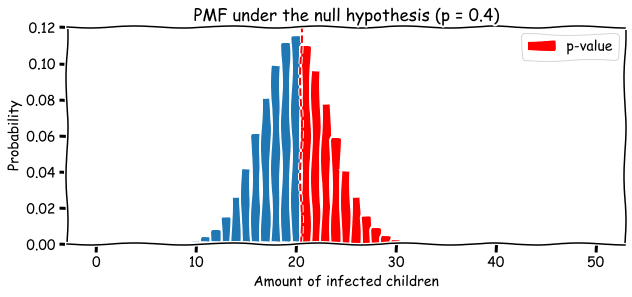

In [18]:
h_0 = 4/10
probs = stats.binom.pmf(k=x, n=n, p=h_0)
temp = probs.copy()
temp[x<k] = 0

plt.figure(figsize=(10,4))
plt.bar(x, probs)
plt.bar(x, temp, color='r', label='p-value')
plt.axvline(k-0.5, linestyle='--', color='r')
plt.title(f'PMF under the null hypothesis (p = {h_0})')
plt.ylabel('Probability')
plt.xlabel('Amount of infected children')
plt.legend()
plt.show()

$$\text{p-value} = \sum_{i=21}^n P(X_i) = P(21) + P(22) + ... + P(50)$$
$$=\binom{50}{21} \left( \frac{4}{10} \right) ^{21} \left( 1 - \frac{4}{10} \right) ^{50-21} + \binom{50}{2} \left( \frac{4}{10} \right) ^{22} \left( 1 - \frac{4}{10} \right) ^{50-22} + ... + \binom{50}{50} \left( \frac{4}{10} \right) ^{50} \left( 1 - \frac{4}{10} \right) ^{50-50}$$
$$\approx 0.439$$

Now we calculate the binomial pmf function with the probability of success $P(\text{MTCT})=0.4$ and p-value if going to be a sum of probabilities that $P(X \geq 21)$. We can see that this value is around 43%, which is much higher than our significance level alpha. Again, we failed to reject the null hypothesis, meaning that there is not enough evidence to claim that the probability of MTCT of HIV is higher than 40%. 
As we can see, NHST is very sensitive to the null hypothesis you choose. Changing the hypotheses (even if the idea behind them stays quite the same) can lead to contradictory results.

In [8]:
p_val = 1 - stats.binom.cdf(k=k-1, n=n, p=h_0)
# equivalent
# p_val = stats.binom_test(x=k, n=n, p=h_0, alternative='greater') 
print(f"p-value = {p_val: .3f}")

p-value =  0.439


#### Confidence Intervals

We could also build a confidence interval to show our uncertainty about the ratio of MTCT. For the large amount of $n$ in binomial trials we can say that random variable $X$ follows a normal distribution with the mean $\hat{p}$ and standard error $\frac{\hat{p}(1-\hat{p})}{n}$

$$X \sim \mathcal{N} \big( \mu = \hat{p}, SE = \frac{\hat{p}(1-\hat{p})}{n} \big)$$

Once we have a normal distribution we can easily calculate 95% CI:

$$(1-\alpha) \% CI: \mu \pm Z_{1-\alpha/2} \cdot SE$$

* $\hat{p} = \frac{k}{n}=0.42$
* $Z_{1-0.05/2} = 1.96$
* $SE = \frac{0.42(1-0.42)}{50} \approx 0.07$

$$95\% CI: (0.28, 0.56)$$

In other words, we are 95% confident that true proportion of MTCT lies in the interval $(0.28, 0.56)$. However, we don't know if our CI has included true probability (it is either 0 or 1). We can also say, that if we would get more sample of the size 50 and calculated the CI for each of them, 95% of these CIs would hold a true value.

In [9]:
p_hat = k/n
z_score = stats.norm.ppf(0.975) 
se = np.sqrt((k/n * (1-k/n))/n)

lwr, uppr = p_hat - z_score*se, p_hat + z_score*se

# equivalent
# proportion_confint(count=k, nobs=n, alpha=0.05, method='normal')

print(f"95% CI for the proportion: ({lwr:.2f}, {uppr:.2f}).")

95% CI for the proportion: (0.28, 0.56).


### Bayesian Approach

Now it's turn for Bayesian approach. Under this framework you could specify two distinct hypotheses and check which one is more likely to be true.

* $H_1$: probability of MTCT of HIV is 50%, $P(\text{MTCT})=0.5$;
* $H_2$: probability of MTCT of HIV is 40%, $P(\text{MTCT})=0.4$.

We can apply Bayes rule to calculate the posterior probability after we observed the data.

$$P(\text{Model}|\text{Data}) = \frac{P(\text{Data|Model}) \cdot P(\text{Model})}{P(\text{Data})}$$

* $P(\text{Data|Model})$ is the **likelihood**, or probability that the observed data would happen given that model (hypothesis) is true. 
* $P(\text{Model})$ is the **prior probability** of a model (hypothesis).
* $P(\text{Data})$ is the probability of a given data. It is also sometimes referred to as **normalizing constant** to assure that posterior probability function sums up to one.
* $P(\text{Model}|\text{Data})$ is the **posterior probability** of the hypothesis given the observed data.

Assume that we have no prior information about the MTCT so we believe that both hypotheses have equal chances to be true. Prior: $P(H_1)=P(H_2)=\frac{1}{2}$. Note that prior probability mass function has to sum up to 1.

**Likelihood**:

* $P(k = 21 | H_1 \text{ is true}) = \binom{n}{k} \cdot P(H_1)^k \cdot (1-P(H_1))^{n-k}$

    $= \binom{50}{21} \cdot 0.5^{21} \cdot (1-0.5)^{50-21}=0.0598$

* $P(k = 21 | H_2 \text{ is true}) = \binom{n}{k} \cdot P(H_2)^k \cdot \left( 1-P(H_2) \right) ^{n-k}$

    $= \binom{50}{21} \cdot 0.4^{21} \cdot (1-0.4)^{50-21}=0.109$

**Posterior probabilities**:

* $P(H_1 \text{ is true|}k = 21) = \frac{P(k = 21 | H_1 \text{ is true}) \cdot P(H_1)}{P(\text{k = 21})}$

* $P(H_2 \text{ is true|}k = 21) = \frac{P(k = 21 | H_2 \text{ is true}) \cdot P(H_2)}{P(\text{k = 21})}$

$$P(k=21)=P(k = 21 | H_1 \text{ is true}) \cdot P(H_1) + P(k = 21 | H_2 \text{ is true}) \cdot P(H_2)$$

$$=0.0598 \cdot 0.5 + 0.109 \cdot 0.5 = 0.084$$

* $P(H_1 \text{ is true|}k = 21) = 0.354$
* $P(H_2 \text{ is true|}k = 21) = 1 - P(H_1 \text{ is true|}k = 21) = 0.646$

As we can see, the probability of the second hypothesis ($P(MTCT) = 40\%$) equals 64.6%, whereas the probability of the first hypothesis ($P(MTCT) = 50\%$) equals 35.4%.

If we want to check if there is enough evidence against one of the hypothesis, we can use the **Bayes factor** (which is kind of analog on Frequentist's p-value).

> The Bayes factor is a likelihood ratio of the marginal likelihood of two competing hypotheses, usually a null and an alternative.

$$\text{BF}(H_2:H_1)= \frac{\text{Posterior Odds}}{\text{Prior Odds}}$$
$$\text{Posterior Odds} = PO(H_2:H_1) = \frac{P(H_2 \text{ is true}|k=21)}{P(H_1\text{ is true}|k=21)}$$
$$\text{Prior Odds} = PrO(H_2:H_1) = \frac{P(H_2)}{P(H_1)}$$

$$\text{BF}(H_2:H_1)= \frac{\frac{0.646}{0.354}}{\frac{0.5}{0.5}} \approx 1.82$$

To interpret the value we can reffer to Harold Jeffreys interpretation table:

<center><img src="https://www.researchgate.net/publication/320376135/figure/tbl1/AS:614127873568776@1523430903196/The-Evidence-Categories-for-the-Bayes-Factor-BF-ij-as-given-by-Jeffreys-1961.png" width="500"></img></center>

Hence we can see there is **not enough supporting evidence for $H_2$** (that the MTCT rate is 40%).

In [10]:
prior = {'h_1': .5, 'h_2': .5}
model = {'h_1': .5, 'h_2': .4}
likelihood = {'h_1': stats.binom.pmf(k=k, n=n, p=model['h_1']),
              'h_2': stats.binom.pmf(k=k, n=n, p=model['h_2'])}
norm_const = (likelihood['h_1']*prior['h_1'] + likelihood['h_2']*prior['h_2'])
posterior = {'h_1': likelihood['h_1']*prior['h_1'] / norm_const,
             'h_2': likelihood['h_2']*prior['h_2'] / norm_const}

bf = (posterior['h_2']/posterior['h_1']) / (prior['h_2']/prior['h_1'])
print(f"Bayes Factor (H2:H1) = {bf:.2f}")

Bayes Factor (H2:H1) = 1.82


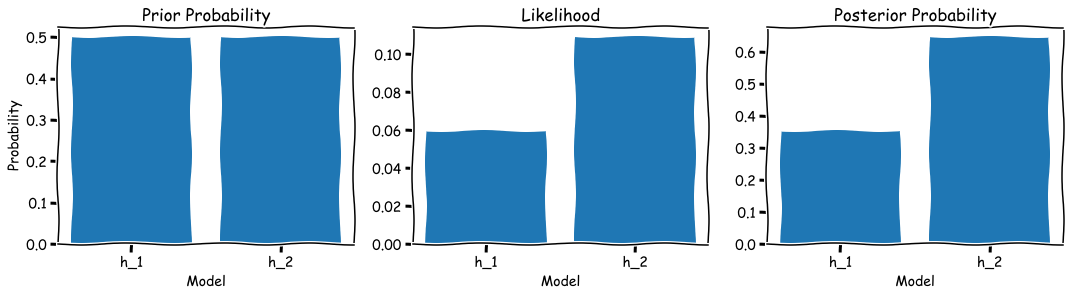

In [11]:
plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.bar(x=prior.keys(), height=prior.values())
plt.xlabel('Model')
plt.ylabel('Probability')
plt.title('Prior Probability')

plt.subplot(132)
plt.bar(x=likelihood.keys(), height=likelihood.values())
plt.xlabel('Model')
plt.title('Likelihood')

plt.subplot(133)
plt.bar(x=posterior.keys(), height=posterior.values())
plt.xlabel('Model')
plt.title('Posterior Probability')

plt.show()

#### Beta-Binomial Conjugate Family and Credible Intervals

We have specified two distinct hypothesis $H_1$ and $H_2$. But also we could define the whole posterior probability distribution function of an unknown parameter $P(\text{MTCT})$. 

Let's assume that we have no prior information about the probability of HIV transmission and $P(\text{MTCT})$ can take any value on the $[0,1]$ range. Or in other words $P(\text{MTCT})$ follows a uniform distribution $P(\text{MTCT}) \sim \text{unif}(0,1)$. For the reasons, that will not be discussed here, we are going to replace the Uniform distribution with Beta distribution $\text{Beta}(\alpha,\beta)$ with parameters $\alpha=1$, $\beta=1$, $P(\text{MTCT}) \sim \text{Beta}(1,1)$, which is exactly like the uniform. It just makes calculations (and life) easier since Beta and Binomial distribution form a **conjugate family**. Likelihood still follows Binomial distribution.

Now, in order to find the posterior distribution we can just update the values of Beta distribution:

* $\alpha^* = \alpha + k$ 
* $\beta^* = \beta + n - k$ 

*Note: I skipped the calculations that explain how $\alpha^*$ and $\beta^*$ were obtained, but you can find them here.*

The expected value of the Beta distribution is:

$$E(x) = \frac{\alpha}{\alpha+\beta}$$

To summarize:

* Prior: $P(\text{MTCT}) \sim \text{Beta}(\alpha=1,\beta=1)$
* Likelihood: $P \big( k = 21 | P(\text{MTCT}) \big) \sim B(n, P(\text{MTCT}))$

    $= \binom{n}{k} \cdot P(\text{MTCT})^k \cdot \big( 1-P(\text{MTCT}) \big) ^{n-k}$
* Posterior: $P(\text{MTCT}) \sim \text{Beta}(\alpha^*=\alpha + k,\beta^* = \beta + n - k)$

After we find the posterior distribution we can derive the **credible interval** (CrI) which will tell us the probability of our unknown parameter $P$. Usually it is find as a narrowest interval with the desired area (like 0.95).

Number of trials: 50
Number of successes: 21
Prior mean: 0.5
Posterior mean: 0.42
95% credible interval: (0.29, 0.56)


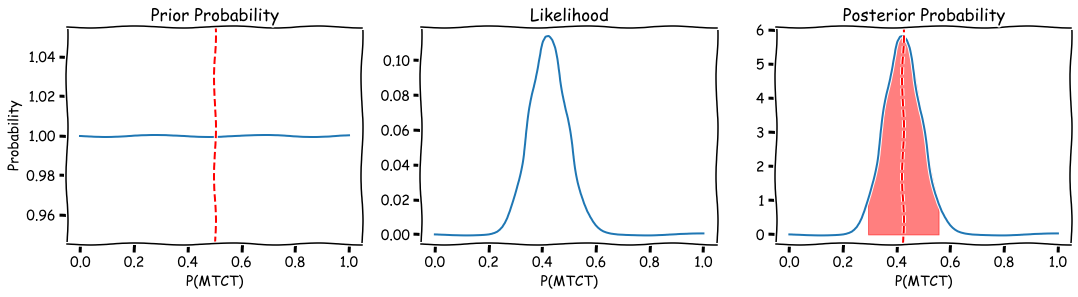

In [12]:
binom_beta(a=1, b=1, n=n, k=k)

What can we tell from these three plots? First, we knew nothing about our parameter $P(\text{MTCT})$, it could be any value from 0 to 1 with the expected value of 0.5. After we get 21 out of 50 HIV-positive children we could calculate what is the probability of obtaining such results under each value of $P(\text{MTCT})$ in the $[0,1]$ range (likelihood). And finally, we were able to update our probability distribution function to get the posterior probabilities. We see, that given the data, expected value for the $P(\text{MTCT})$ is 0.42. Real value of $P(\text{MTCT})$ is in the range $(0.29, 0.56)$ with the probability of 95% (CrI).

The question that could be asked here is what would happen if we chose wrong priors, would we get different results? This might be the case. However, with the relatively large amount of trials, posterior distribution rely more on a likelihood, rather than prior probability distribution so priors don't have a big weight on the results. 

Let's say that we believe that probability of mother-to-child transmission is definitely bigger than the random chance (0.5) with the mean 0.75. We can use parameters $\alpha=15$, $\beta=5$ for this.

Number of trials: 50
Number of successes: 21
Prior mean: 0.75
Posterior mean: 0.51
95% credible interval: (0.4, 0.63)


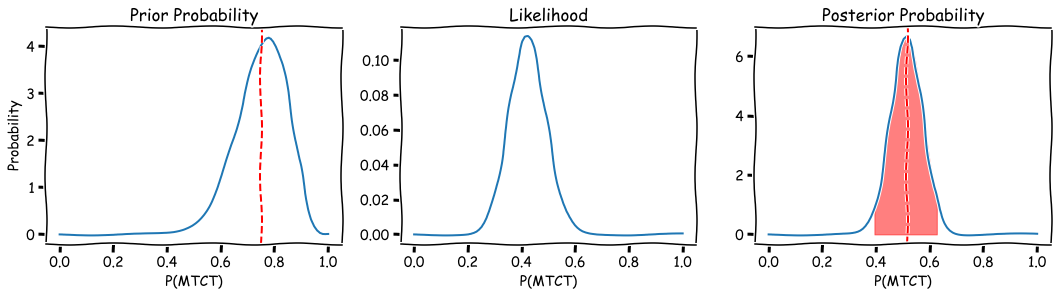

In [13]:
binom_beta(a=15, b=5, n=n, k=k)

As we can see, posterior distribution has not shifted that much, meaning the priors didn't have so much weight. 

Now imagine that we have 5 times more observations (with the same ratio 0.42):

Number of trials: 250
Number of successes: 105
Prior mean: 0.75
Posterior mean: 0.44
95% credible interval: (0.39, 0.5)


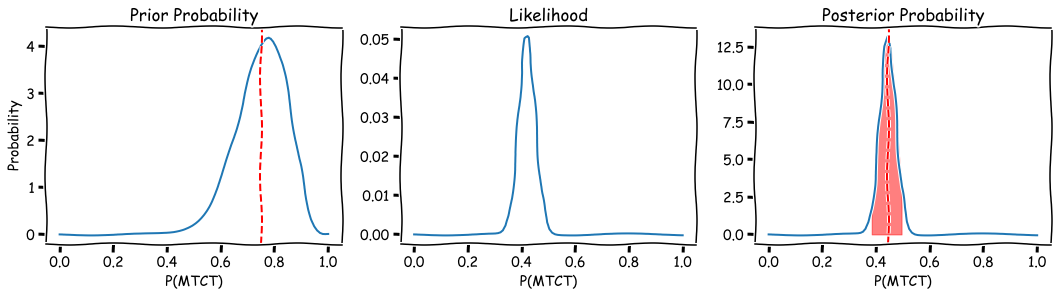

In [14]:
binom_beta(a=15, b=5, n=n*5, k=k*5)

Shape of the posterior distribution looks more like shape of likelihood and now the credible interval became narrower, meaning that we have decreased uncertainty about the unknown parameter $P(\text{MTCT})$.

## Summary

| Frequentist's Approach | Bayesian Approach |
|:--|:--|
| Doesn't rely on prior information about the unknown | Relies on prior information about the unknown (but prior beliefs become less significant as the sample size increases) |
| Sensitive to the null hypothesis | Is not sensitive to hypotheses |
| Estimates the degree of uncertainty using confidence intervals | Estimates the degree of uncertainty using credible intervals |
| Cannot distinguish the probability of a true value in a CI (either 0 or 1) | Can distinguish the probability of a true value in a CrI |

https://www.who.int/hiv/topics/mtct/en/

https://en.wikipedia.org/wiki/P-value

https://en.wikipedia.org/wiki/Bayes_factor

https://en.wikipedia.org/wiki/Conjugate_prior

https://en.wikipedia.org/wiki/Beta-binomial_distribution

https://statswithr.github.io/book/
